# Roll varying stiffness
This notebook is exploring the varying stiffness...

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 15, 10

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian, RolldecayDirectImproved
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_estimator_improved import DirectEstimatorImproved
import rolldecayestimators.direct_estimator_improved as direct_estimator_improved

from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from rolldecay.system_identification import load, fit_predict, plot_pipeline
import copy
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
import docs

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
roll_decay_tests = db.session.query(Run).filter(Run.test_type=='roll decay')

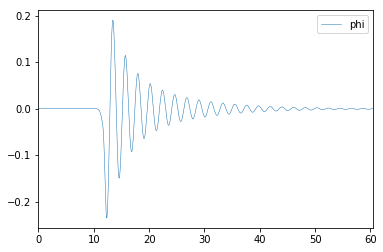

In [5]:
db_run = roll_decay_tests[0]  # Interesting run... natural frequency changes...
scale_factor = db_run.model.scale_factor

df = load(db_run)
df.plot(y='phi')


In [6]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(15), phi_min=np.deg2rad(0.2))
offset_transformer = OffsetTransformer()
bounds = {
    'omega0':(0,np.inf) # Only positive natural frequency
}

## Quadratic direct

In [7]:
direct_estimator = DirectEstimator(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('direct_estimator', direct_estimator)]
        
pipeline_direct = Pipeline(steps) # define the pipeline object.

In [8]:
s, _pipline = fit_predict(df, pipeline=pipeline_direct, scale_factor=scale_factor)
s

{'d': 0.5533651423636616,
 'mean_damping': 0.05006389188826278,
 'omega0': 0.3893557345425755,
 'score': 0.8931189306137034,
 'zeta': 0.04496602581019173}

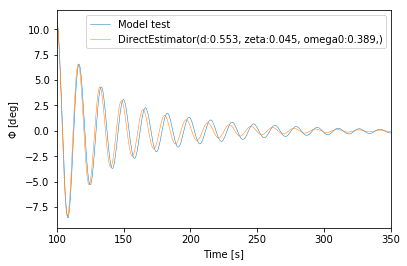

In [9]:
fig,ax = plt.subplots()
estimator = _pipline[-1]
estimator.plot_fit(ax=ax)

save_path = os.path.join(docs.path_presentation1,'varying_stiffness.png')
fig.savefig(save_path,transparent=True, dpi=200, bbox_inches='tight')

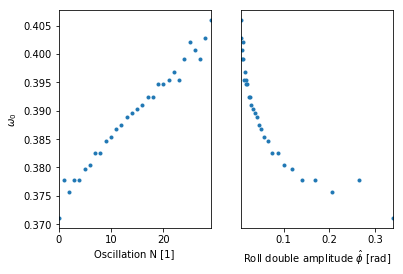

In [10]:
fig,axes=plt.subplots(ncols=2)

ax=axes[0]
estimator.calculate_amplitudes_and_damping()
X_amplitudes = estimator.X_amplitudes.copy()
X_amplitudes.reset_index(inplace=True)
X_amplitudes.plot(y='omega0', style='.', ax=ax)
ax.set_xlabel('Oscillation N [1]')
ax.set_ylabel('$\omega_0$')
#ax.set_title('Natural frequency $ \omega_0 $ for each oscillation')
ax.legend().set_visible(False)

ax=axes[1]
X_amplitudes = estimator.X_amplitudes.copy()
X_amplitudes.reset_index(inplace=True)
X_amplitudes.plot(x='phi',y='omega0', style='.', ax=ax)
ax.set_xlabel('Roll double amplitude $\hat{\phi} $ [rad]')
ax.set_ylabel('$\omega_0$')
#ax.set_title('Natural frequency $ \omega_0 $ vs. roll double amplitude $\hat{\phi} $')
ax.get_yaxis().set_visible(False)
ax.legend().set_visible(False)

save_path = os.path.join(docs.path_presentation1,'varying_stiffness2.png')
fig.savefig(save_path,transparent=True, dpi=200, bbox_inches='tight')

## Direct estimator improved
Add varying stiffness:

In [11]:
latex = vlatex(direct_estimator_improved.roll_diff_equation)
display(Math(latex))

<IPython.core.display.Math object>

In [12]:
direct_estimator_improved_ = DirectEstimatorImproved(bounds=bounds)

steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
    ('direct_estimator_improved', direct_estimator_improved_)]
        
pipeline_direct_improved = Pipeline(steps) # define the pipeline object.

In [13]:
s, _pipline2 = fit_predict(df, pipeline=pipeline_direct_improved, scale_factor=scale_factor)
s

{'d': 0.5338912784308114,
 'dGM': -0.05346758608702651,
 'mean_damping': 0.04633112510557161,
 'omega0': 0.3842001334338686,
 'score': 0.9932738175708705,
 'zeta': 0.04141266163664974}

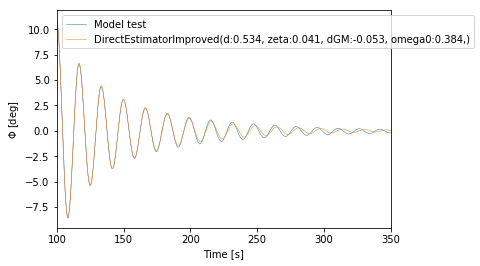

In [14]:
fig,ax = plt.subplots()
estimator2 = _pipline2[-1]
estimator2.plot_fit(ax=ax)

save_path = os.path.join(docs.path_presentation1,'varying_stiffness3.png')
fig.savefig(save_path,transparent=True, dpi=200, bbox_inches='tight')